# Netflix Recommender System

# Importing libraries and Data

In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0}) # https://stackoverflow.com/questions/21884271/warning-about-too-many-open-figures.
import seaborn as sns
sns.set_style('darkgrid')  # all figures background changed to gridlines
from datetime import datetime

from matplotlib.ticker import FuncFormatter ## To get proper formatting for tickers or coordinate axis
from scipy import sparse ## to build sparse matrix
from sklearn.metrics.pairwise import cosine_similarity # to build user user and item item similarity


from jupyterthemes import jtplot # for my jupyter notebook only, this is to fix problem with dark theme in jupyter
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [6]:
##data overview
with open('.\Applied AI\data\combined_data_1.txt') as f:
    line = f.readlines()
    f.close()
line[0:20]

['1:\n',
 '1488844,3,2005-09-06\n',
 '822109,5,2005-05-13\n',
 '885013,4,2005-10-19\n',
 '30878,4,2005-12-26\n',
 '823519,3,2004-05-03\n',
 '893988,3,2005-11-17\n',
 '124105,4,2004-08-05\n',
 '1248029,3,2004-04-22\n',
 '1842128,4,2004-05-09\n',
 '2238063,3,2005-05-11\n',
 '1503895,4,2005-05-19\n',
 '2207774,5,2005-06-06\n',
 '2590061,3,2004-08-12\n',
 '2442,3,2004-04-14\n',
 '543865,4,2004-05-28\n',
 '1209119,4,2004-03-23\n',
 '804919,4,2004-06-10\n',
 '1086807,3,2004-12-28\n',
 '1711859,4,2005-05-08\n']

In [7]:
# loading, joining and combining the data
start = datetime.now()
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')

    row = list()
    files = ['.\Applied AI\data\combined_data_1.txt', '.\Applied AI\data\combined_data_2.txt']
    
    for file in files:

        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f:
                line = line.strip() # get a line from start till '\n'
                if line.endswith(':'):
                    movie_id = line.replace(':','')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0,movie_id) # (position,value)
                    data.write(','.join(row))
                    data.write('\n')
            print('Done\n')
        f.close()
    data.close()
        
print('Time Taken', datetime.now()-start)

Time Taken 0:00:00


In [110]:
if  os.path.isfile('data.csv'):
    df = pd.read_csv('data.csv',delimiter=',',names=['movie', 'user','rating','date'])
    df.date = pd.to_datetime(df.date)
    print('Done.\n')
    # we are arranging the ratings according to time.
    print('Sorting the dataframe by date..')
    df.sort_values(by='date', inplace=True)

Done.

Sorting the dataframe by date..


## Checking for Nan Values

In [111]:
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


## Removing Duplicates

In [112]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool) 
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


## Basic information on Data set

In [113]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 51031355
Total No of Users   : 478018
Total No of movies  : 9210


## Splitting Data into Test and Train(checkpoint)

In [10]:
if not os.path.isfile('train.csv') and not os.path.isfile('test.csv'):
    train_set, test_set= np.split(df, [int(.67 *df.shape[0])])
    train_set.to_csv('train.csv',index=False)
    test_set.to_csv('test.csv',index=False)
else:
    train_df = pd.read_csv("train.csv", parse_dates=['date'])
    test_df = pd.read_csv("test.csv", parse_dates=['date'])

In [11]:
print('Shape of Train : {} and Test {}'.format(train_df.shape,test_df.shape))

Shape of Train : (34191007, 4) and Test (16840348, 4)


## EDA on Train

In [36]:

def millions(x, pos):
    '''The two args are the value and tick position'''
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)

### Distribution of Ratings

Text(0, 0.5, 'No. of Ratings(Millions)')

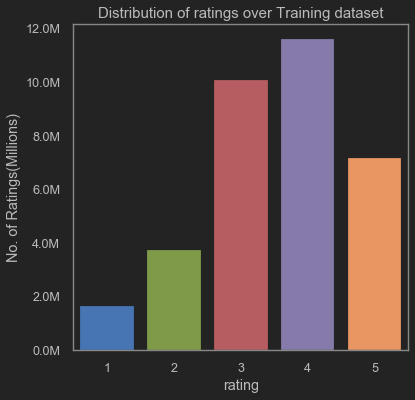

In [37]:
fig, ax = plt.subplots(figsize=(6,6))
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel('No. of Ratings(Millions)')

### Fetching day from date 

In [14]:
train_df['day_of_week'] = train_df.date.dt.day_name()

train_df.tail()

,movie,user,rating,date,day_of_week
34191002,1719,1790621,2,2005-05-16,Monday
34191003,7957,2191815,3,2005-05-16,Monday
34191004,1050,2239537,4,2005-05-16,Monday
34191005,7928,1256381,3,2005-05-16,Monday
34191006,4210,2018587,3,2005-05-16,Monday


### Number of ratings per month

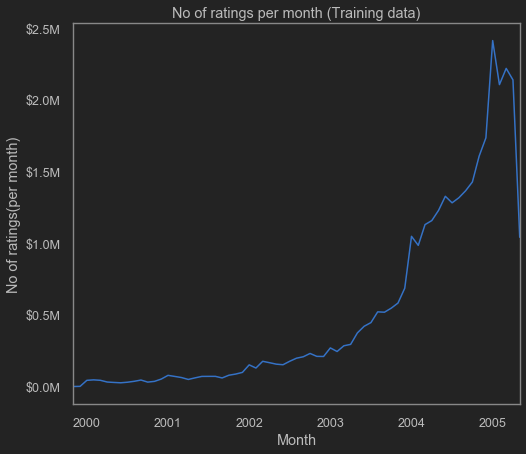

In [19]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.yaxis.set_major_formatter(formatter)
plt.show()

### Number of Ratings per user

In [20]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user
305344     8564
2439493    7847
387418     7552
1639792    5100
1461435    4497
Name: rating, dtype: int64

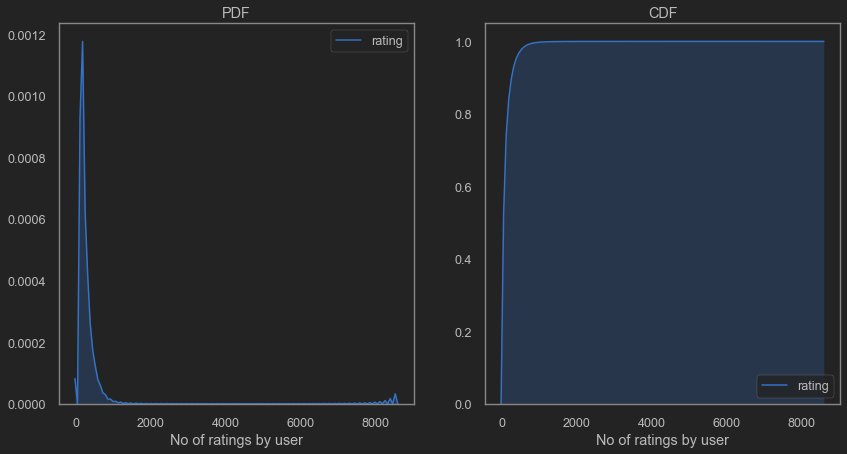

In [21]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

### Number of ratings on each day of the week

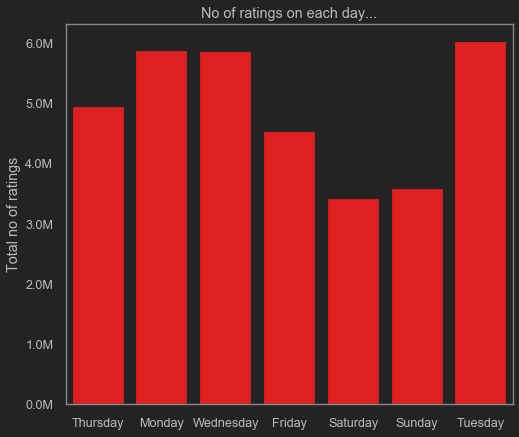

In [38]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax,color='red')
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
ax.yaxis.set_major_formatter(formatter)
plt.xlabel('')
plt.show()

In [ ]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

In [33]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.05,0.05))

In [32]:
quantiles

0.00       1
0.05       3
0.10       5
0.15       8
0.20      11
0.25      14
0.30      18
0.35      23
0.40      29
0.45      36
0.50      44
0.55      54
0.60      66
0.65      81
0.70      99
0.75     122
0.80     153
0.85     195
0.90     259
0.95     375
1.00    8564
Name: rating, dtype: int64

In [34]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 375)) )


 No of ratings at last 5 percentile : 17413



### Creating Sparse Matrix from train and test data frame (checkpoint)

In [44]:
####  TRAIN
if not os.path.isfile('train_sparse_matrix.npz'):
    %time train_sparse_matrix = sparse.csr_matrix((train_df['rating'].values,(train_df['user'].values,train_df['movie'].values)),)
    print('Shape of Matrix is {}'.format(train_sparse_matrix.shape))
    %time sparse.save_npz('train_sparse_matrix.npz',train_sparse_matrix)
    print('Done...')
    
else:
    print('Loading Sparse Matrix into memory from Hard Disk')
    %time train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
    print('Done.....')
    

Wall time: 4.69 s
Shape of Matrix is (2649430, 9211)
Wall time: 20.3 s
Done...


In [58]:
us,mv = train_sparse_matrix.shape
non_zero_element = train_sparse_matrix.count_nonzero()
print('Sparsity of train matrix: {} %'.format((1 - (non_zero_element/(us*mv)))*100) )

Sparsity of train matrix: 99.85989531436253 %


In [46]:
####  TEST
if not os.path.isfile('test_sparse_matrix.npz'):
    %time test_sparse_matrix = sparse.csr_matrix((test_df['rating'].values,(test_df['user'].values,test_df['movie'].values)))
    print('Shape of Matrix is {}'.format(test_sparse_matrix.shape))
    %time sparse.save_npz('test_sparse_matrix.npz',test_sparse_matrix)
    print('Done...')
    
else:
    print('Loading Sparse Matrix into memory from Hard Disk')
    %time test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')
    print('Done.....')
    

Wall time: 12.7 s
Shape of Matrix is (2649430, 9211)
Wall time: 11.1 s
Done...


In [61]:
us,mv = test_sparse_matrix.shape
non_zero_element = test_sparse_matrix.count_nonzero()
print('Sparsity of test matrix: {} %'.format((1 - (non_zero_element/(us*mv)))*100) )

Sparsity of test matrix: 99.93099320933818 %


### Average Ratings per User and per movie

In [89]:
def get_dict_average(sparse_matrix, ofuser):

    ax = 1 if ofuser else 0
    
    sum_of_rating = sparse_matrix.sum(axis=ax).A1 #ravel --> (x.1) = reshape(-1,1)--> still a 2D array. A1 = (x.) --> 1D array
    number_of_rating = (sparse_matrix!=0).sum(axis=ax).A1  ##https://stackoverflow.com/questions/3797158/counting-non-zero-elements-within-each-row-and-within-each-column-of-a-2d-numpy
    
    u,m = sparse_matrix.shape
    
    average_rating = { i: sum_of_rating[i]/number_of_rating[i] for i in range(u if ofuser else m) if number_of_rating[i]!=0 }

    return average_rating
    

In [99]:
train_averages = dict()
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.553178384011913}

In [104]:
train_averages['user'] = get_dict_average(train_sparse_matrix,ofuser=True)
train_averages['movie'] = get_dict_average(train_sparse_matrix,ofuser=False)

Wall time: 95.7 ms
Wall time: 59.3 s
Wall time: 11 ms
Wall time: 374 ms


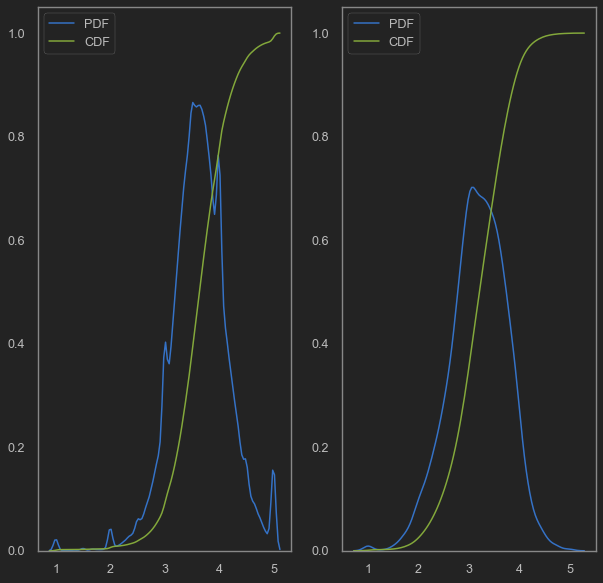

In [109]:
user_average = [r for r in train_averages['user'].values()]
movie_average = [r for r in train_averages['movie'].values()]

kwargs = {'cumulative': True}  # https://stackoverflow.com/questions/39297523/plot-cdf-cumulative-histogram-using-seaborn-python

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
%time sns.distplot(user_average, ax=ax1,hist=False,label = 'PDF')
%time sns.distplot(user_average, ax=ax1,hist=False,label = 'CDF',kde_kws=kwargs)

%time sns.distplot(movie_average, ax=ax2,hist=False,label = 'PDF')
%time sns.distplot(movie_average, ax=ax2,hist=False,label = 'CDF',kde_kws=kwargs)

### Cold Start Problem

In [114]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 478018

Number of Users in Train data : 347904

No of Users that didn't appear in train data: 130114(27.22 %) 
 


In [115]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 9210

Number of Users in Train data : 8764

No of Movies that didn't appear in train data: 446(4.84 %) 
 


### Similarity Matrix for User-User and Movie-Movie at runtime,
- we can build a matrix too, but matrix is not useful for EDA, if we train ML model on the matrix then it is

In [167]:
def user_similarity(user_id,top=10):
    try:
  h     sim = cosine_similarity(train_sparse_matrix.getrow(user_id), train_sparse_matrix).ravel()
        tim = np.sort(sim)
        return dict(zip(sim.argsort()[-top:],np.round(tim[-top:],2)))
    except:
        return 'User Id does not exist'
def movie_similarity(movie_id,top=10):
    try:
        sim = cosine_similarity(train_sparse_matrix.T.getrow(movie_id), train_sparse_matrix.T).ravel()
        tim = np.sort(sim)
        return dict(zip(sim.argsort()[-top:],np.round(tim[-top:],2)))
    except:
        return 'Movie Id Does not exist'

{2578: 0.19,
 1408: 0.19,
 4155: 0.19,
 9170: 0.19,
 2015: 0.2,
 5856: 0.21,
 1264: 0.22,
 6917: 0.23,
 2905: 0.23,
 534: 1.0}

### Ascertaining the movie similar function is correct or not

In [213]:
movie_titles = pd.read_csv(".\Applied AI\data\movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1") 
mov = movie_similarity(67,10)
mov.keys()
movie_titles.loc[mov.keys()]

Tokenization took: 6.98 ms
Type conversion took: 15.96 ms
Parser memory cleanup took: 0.00 ms


,year_of_release,title
movie_id,,
4111,1998.0,Bram Stoker's Shadowbuilder
938,2002.0,Scarecrow
7520,1997.0,The Creeps
7573,2000.0,Kindred: The Embraced: The Complete Vampire Co...
4667,1996.0,Vampirella
1900,1997.0,Club Vampire
1688,1993.0,To Sleep With a Vampire
4044,1998.0,Subspecies 4: Bloodstorm
323,1999.0,Modern Vampires


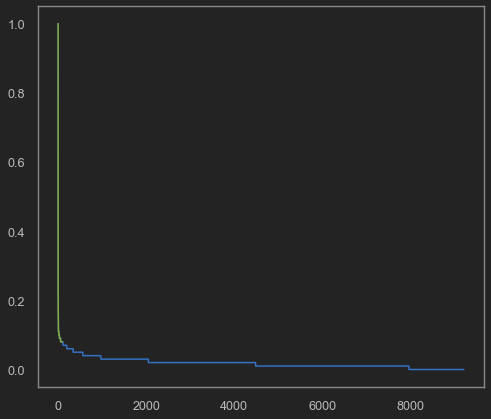

In [212]:
p = np.sort(list(movie_similarity(67,10000).values()))[::-1]
q = np.sort(list(movie_similarity(67,100).values()))[::-1]
plt.plot(p,  label='All the ratings')
plt.plot(q,  label='top 100')
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)

# Machine Learning Model

## Building sample of data for faster training

In [363]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies,file_name):
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)
    
    
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))
    sparse.save_npz(file_name,sample_sparse_matrix)
    
    return sample_sparse_matrix

In [480]:
if os.path.isfile('sample_train_sparse_matrix.npz'):
    sample_train_sparse_matrix = sparse.load_npz('sample_train_sparse_matrix.npz')
else: 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,file_name='sample_train_sparse_matrix.npz')

In [481]:
if os.path.isfile('sample_test_sparse_matrix.npz'):
    sample_test_sparse_matrix = sparse.load_npz('sample_test_sparse_matrix.npz')
else: 
    %time sample_test_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=5000, no_movies=500,file_name='sample_test_sparse_matrix.npz')

## Featurizing data for training model

In [488]:
sample_train_averages = dict ()
## 1st feature
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

## 2nd Feature
sample_train_averages['user'] = get_dict_average(sample_train_sparse_matrix, ofuser=True)

## 3rd Feature
sample_train_averages['movie'] =  get_dict_average(sample_train_sparse_matrix, ofuser=False)


### Featurizing other features for train

In [476]:
############################################################
# It took me almost 10 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 18636 tuples for the dataset..



KeyboardInterrupt: 

In [489]:
reg_train = pd.read_csv('reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

### Featurizing test Data

In [490]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [491]:
start = datetime.now()

if os.path.isfile('reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open('reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

preparing 18636 tuples for the dataset..



FileNotFoundError: [Errno 2] No such file or directory: 'sample/small/reg_test.csv'

In [493]:
reg_test_df = pd.read_csv('reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


### Transforming train data for surprise model

In [508]:
from surprise import Reader, Dataset
from sklearn.metrics import mean_squared_error

reader = Reader(rating_scale=(1,5))
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)
trainset = train_data.build_full_trainset() 

### Transforming Test data 

In [509]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))


## Applying Machine Learning models(XGBoost,Surprise)


In [510]:
## Dict which will store performance of every model
models_evaluation_train = dict()
models_evaluation_test = dict()


In [511]:
## Function which i will use in every model
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

def run_xgboost(algo,  x_train, y_train, x_test, y_test):
    
    train_results = dict()
    test_results = dict()

    %time algo.fit(x_train, y_train, eval_metric = 'rmse')
    y_train_pred = algo.predict(x_train)
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    print('\nTrain DATA')
    print('-'*30)
    print('RMSE : ', rmse_train)
    print('MAPE : ', mape_train)
    
    
     # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    print('\nTEST DATA')
    print('-'*30)
    print('RMSE : ', rmse_test)
    print('MAPE : ', mape_test)
    return train_results, test_results


In [530]:
np.random.seed(10)

def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100
def run_surprise(algo, trainset, testset, verbose=True): 
    train = dict()
    test = dict()
    
    %time algo.fit(trainset)    
    train_preds = algo.test(trainset.build_testset())
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    train_rmse, train_mape = get_errors(train_preds)
    print('-'*15)
    print('Train Data')
    print('-'*15)
    print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    test_preds = algo.test(testset)
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    test_rmse, test_mape = get_errors(test_preds)
    print('-'*15)
    print('Test Data')
    print('-'*15)
    print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    return train, test


    
    
    
    

### XGBoost with initial 13 features

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed:  3.4min finished


[16:18:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:18:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 16.5 s

Train DATA
------------------------------
RMSE :  0.8151641111622587
MAPE :  24.078567252365644
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1321185218749736
MAPE :  32.585192242504945


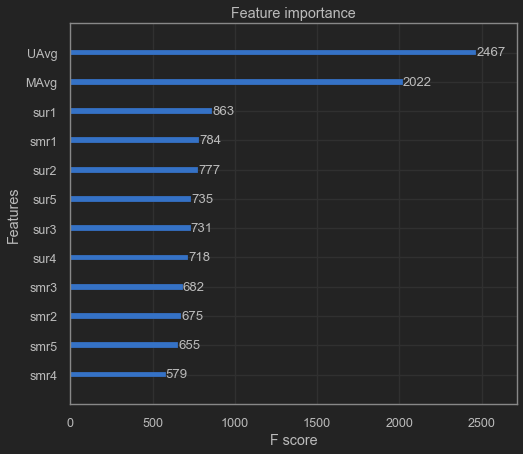

In [522]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']
hyperparameter_xgb = xgb.XGBRegressor(random_state=15)

parameters = {'silence':[0],
              'n_estimator':[100,300,500],
              'max_depth':[5,6,7],
              'learning_rate': [.03, 0.05, .07],
              'objective':['reg:linear']
             }
xgb_grid = GridSearchCV(hyperparameter_xgb,parameters,cv=2,n_jobs=5,verbose=True)
xgb_grid.fit(x_train,y_train)

first_xgb = xgb.XGBRegressor(random_state=15,learning_rate=xgb_grid.best_params_['learning_rate'],n_estimator=xgb_grid.best_params_['n_estimator'],
                             max_depth=xgb_grid.best_params_['max_depth'],objective=xgb_grid.best_params_['objective'])

train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()


### Surprise Baseline Model

In [531]:
from surprise import BaselineOnly 



bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options)
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Estimating biases using sgd...
Wall time: 804 ms
---------------
Train Data
---------------
RMSE : 0.9347153928678286

MAPE : 29.389572652358183

---------------
Test Data
---------------
RMSE : 1.0730330260516174

MAPE : 35.04995544572911



### XGBoost initial 13 features + surprise baseleine

In [532]:
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403


In [533]:
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679


Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  3.3min
[Parallel(n_jobs=5)]: Done  54 out of  54 | elapsed:  4.2min finished


[16:45:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 16 s

Train DATA
------------------------------
RMSE :  0.8372931748429113
MAPE :  24.888412941737972
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0762698328698515
MAPE :  34.49787251325817


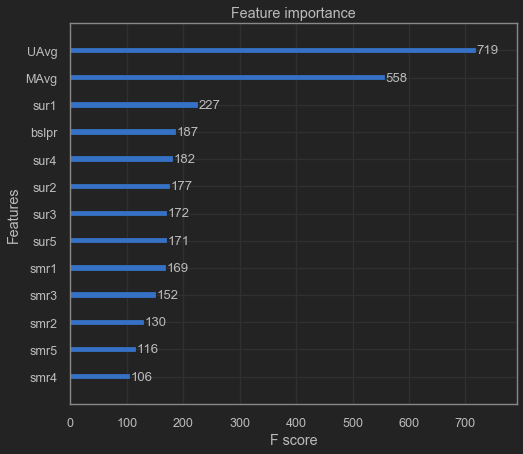

In [534]:
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

hyperparameter_xgb = xgb.XGBRegressor(random_state=15)

parameters = {'silence':[0],
              'n_estimator':[100,300,500],
              'max_depth':[5,6,7],
              'learning_rate': [.03, 0.05, .07],
              'objective':['reg:linear']
             }
xgb_grid = GridSearchCV(hyperparameter_xgb,parameters,cv=2,n_jobs=5,verbose=True)
xgb_grid.fit(x_train,y_train)

xgb_bsl = xgb.XGBRegressor(random_state=15,learning_rate=xgb_grid.best_params_['learning_rate'],n_estimator=xgb_grid.best_params_['n_estimator'],
                             max_depth=xgb_grid.best_params_['max_depth'],objective=xgb_grid.best_params_['objective'])

train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()

